Starting sampling density analysis...
Period: 2021-2024 (4 full years)
Cloud assessment method: strict
Generating random locations...
Generated 30 locations across 3 regions
Analyzing 30 representative locations...
Fetching weather data for 53.434, 5.189...
  Fetching grid point 1/9...
  Fetching grid point 2/9...
  Fetching grid point 3/9...
  Fetching grid point 4/9...
  Fetching grid point 5/9...
  Fetching grid point 6/9...
  Fetching grid point 7/9...
  Fetching grid point 8/9...
  Fetching grid point 9/9...
  Successfully fetched 35,064 hours of weather data
  Clear hours - Strict: 2,465 (7.0%)
  Clear hours - Majority: 2,465 (7.0%)
  Clear hours - Core+Majority: 2,465 (7.0%)
Analyzing sampling for North_Netherlands_001 using strict cloud method...
Fetching weather data for 53.445, 5.859...
  Fetching grid point 1/9...
  Fetching grid point 2/9...
  Fetching grid point 3/9...
  Fetching grid point 4/9...
  Fetching grid point 5/9...
  Fetching grid point 6/9...
  Fetching grid po

  Successfully fetched 35,064 hours of weather data
  Clear hours - Strict: 2,478 (7.1%)
  Clear hours - Majority: 2,478 (7.1%)
  Clear hours - Core+Majority: 2,478 (7.1%)
Analyzing sampling for North_Germany_005 using strict cloud method...
Fetching weather data for 54.056, 9.750...
  Fetching grid point 1/9...
  Fetching grid point 2/9...
  Fetching grid point 3/9...
  Fetching grid point 4/9...
  Fetching grid point 5/9...
  Fetching grid point 6/9...
  Fetching grid point 7/9...
  Fetching grid point 8/9...
  Fetching grid point 9/9...
  Successfully fetched 35,064 hours of weather data
  Clear hours - Strict: 2,463 (7.0%)
  Clear hours - Majority: 2,463 (7.0%)
  Clear hours - Core+Majority: 2,463 (7.0%)
Analyzing sampling for North_Germany_006 using strict cloud method...
Fetching weather data for 54.043, 6.433...
  Fetching grid point 1/9...
  Fetching grid point 2/9...
  Fetching grid point 3/9...
  Fetching grid point 4/9...
  Fetching grid point 5/9...
  Fetching grid point 6/

  Successfully fetched 35,064 hours of weather data
  Clear hours - Strict: 2,646 (7.5%)
  Clear hours - Majority: 2,646 (7.5%)
  Clear hours - Core+Majority: 2,646 (7.5%)
Analyzing sampling for South_Denmark_010 using strict cloud method...


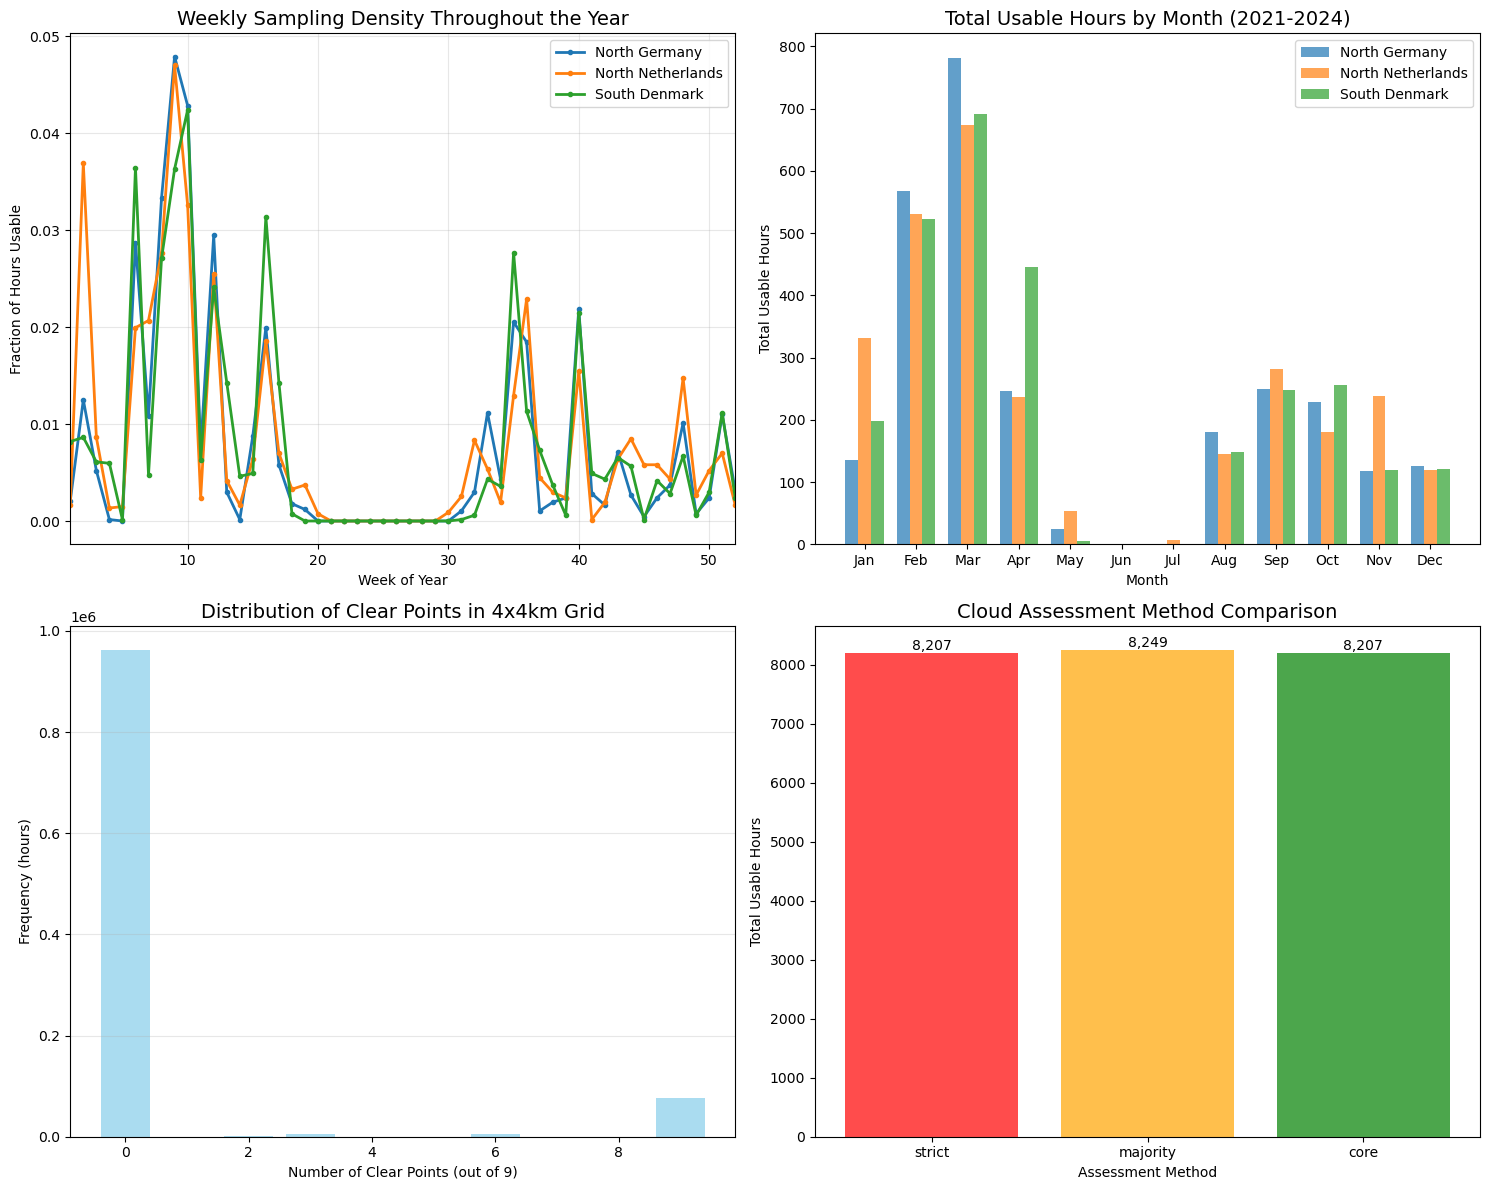


OPTIMIZED SAMPLING DENSITY ANALYSIS REPORT

📊 DATA AVAILABILITY AND LOSSES (4x4km Grid, 3x3 Sampling)
--------------------------------------------------
Total hours in dataset: 1,051,920
Hours excluded by sun (>-18° altitude): 761,921 (72.4%)
Hours remaining after sun filter: 289,999
Hours excluded by moon (>-3° altitude): 156,089 (53.8% of dark hours)
Hours remaining after moon filter: 133,910
Hours excluded by clouds (using strict method): 125,703 (93.9% of moon-free hours)
Final usable hours: 8,207 (0.8% of all hours)

☁️ CLOUD ASSESSMENT ROBUSTNESS
--------------------------------------------------
Clear Points | Hours Available | % of Dark+Moon-free Hours
-------------------------------------------------------
          7 |           8,249 |                   6.2% ←
          9 |           8,207 |                   6.1%

📅 MONTHLY SAMPLING PATTERNS
--------------------------------------------------
Month    | Dark Hours | Dark+NoMoon | Dark+NoMoon+NoClouds | Avg/Location/Month
--

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import ephem
from collections import defaultdict
import random
import warnings
import requests
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')

class SkyBrightnessSampler:
    def __init__(self):
        # Define regions
        self.regions = {
            'North_Netherlands': {'lat_range': (51.5, 53.5), 'lon_range': (3, 7)},
            'North_Germany': {'lat_range': (53, 55), 'lon_range': (6, 10)},
            'South_Denmark': {'lat_range': (54, 56), 'lon_range': (8, 12)}
        }
        
        # Parameters
        self.sun_altitude_threshold = -18  # degrees (astronomical twilight)
        self.moon_altitude_threshold = -3  # degrees
        self.cloud_threshold = 0  # 0% cloud cover threshold for clear skies
        
        # Date range (full calendar years 2021, 2022, 2023, 2024)
        self.start_date = datetime(2021, 1, 1)
        self.end_date = datetime(2024, 12, 31)
        
        self.locations = {}
        self.weather_cache = {}
        
    def generate_locations(self, n_points=10):
        """Generate random locations in each region"""
        print("Generating random locations...")
        
        for region_name, bounds in self.regions.items():
            locations = []
            for i in range(n_points):
                lat = np.random.uniform(bounds['lat_range'][0], bounds['lat_range'][1])
                lon = np.random.uniform(bounds['lon_range'][0], bounds['lon_range'][1])
                locations.append({
                    'id': f"{region_name}_{i+1:03d}",
                    'lat': lat,
                    'lon': lon,
                    'region': region_name
                })
            self.locations[region_name] = locations
        
        total_locations = sum(len(locs) for locs in self.locations.values())
        print(f"Generated {total_locations} locations across {len(self.regions)} regions")
    
    def get_weather_data(self, lat, lon):
        """Fetch weather data with optimized 4x4km grid using 3x3 sampling pattern"""
        cache_key = f"{lat:.3f}_{lon:.3f}"
        
        if cache_key in self.weather_cache:
            return self.weather_cache[cache_key]
        
        try:
            print(f"Fetching weather data for {lat:.3f}, {lon:.3f}...")
            
            # Optimized 3x3 grid covering 4x4km area
            # At ~54°N latitude, 1 degree ≈ 111km, so 2km ≈ 0.018 degrees
            # 3x3 grid with 2km spacing covers 4x4km area with 9 points instead of 25
            grid_offset = 0.018  # 2km offset from center
            
            grid_points = []
            for i in range(-1, 2):  # -1, 0, 1
                for j in range(-1, 2):  # -1, 0, 1
                    grid_lat = lat + i * grid_offset
                    grid_lon = lon + j * grid_offset
                    grid_points.append((grid_lat, grid_lon))
            
            all_cloud_data = []
            
            # Fetch cloud data for each grid point (9 calls instead of 25)
            for idx, (grid_lat, grid_lon) in enumerate(grid_points):
                print(f"  Fetching grid point {idx+1}/9...")
                
                url = "https://archive-api.open-meteo.com/v1/era5"
                params = {
                    "latitude": grid_lat,
                    "longitude": grid_lon,
                    "start_date": "2021-01-01",
                    "end_date": "2024-12-31",
                    "hourly": "cloudcover",
                    "timezone": "UTC"
                }
                
                response = requests.get(url, params=params, timeout=60)
                response.raise_for_status()
                data = response.json()
                
                cloud_cover = data['hourly']['cloudcover']
                all_cloud_data.append(cloud_cover)
                
                # Small delay to be respectful to the API
                import time
                time.sleep(0.1)
            
            # Get times from the first request
            times = pd.to_datetime(data['hourly']['time'])
            
            # Convert to numpy arrays for easier manipulation
            cloud_arrays = [np.array(cloud_data) for cloud_data in all_cloud_data]
            
            # Robust cloud assessment with multiple criteria:
            # 1. Strict: ALL 9 points must have 0% cloud cover
            # 2. Majority: At least 7 out of 9 points have 0% cloud cover
            # 3. Core+Majority: Center point + at least 6 others have 0% cloud cover
            
            # Method 1: All points clear (most strict)
            all_clear_mask = np.all([clouds == 0 for clouds in cloud_arrays], axis=0)
            
            # Method 2: Majority clear (7+ points clear)
            clear_count = np.sum([clouds == 0 for clouds in cloud_arrays], axis=0)
            majority_clear_mask = clear_count >= 7
            
            # Method 3: Core + majority (center + 6 others clear)
            center_clear = cloud_arrays[4] == 0  # Center point is index 4 in 3x3 grid
            core_majority_mask = center_clear & (clear_count >= 7)
            
            weather_df = pd.DataFrame({
                'time': times,
                'clear_4x4km_strict': all_clear_mask,           # All 9 points clear
                'clear_4x4km_majority': majority_clear_mask,    # 7+ points clear
                'clear_4x4km_core': core_majority_mask,         # Center + 6+ others clear
                'clear_point_count': clear_count                # Number of clear points
            })
            weather_df.set_index('time', inplace=True)
            
            self.weather_cache[cache_key] = weather_df
            
            # Print some statistics about cloud coverage
            strict_hours = all_clear_mask.sum()
            majority_hours = majority_clear_mask.sum()
            core_hours = core_majority_mask.sum()
            total_hours = len(weather_df)
            
            print(f"  Successfully fetched {total_hours:,} hours of weather data")
            print(f"  Clear hours - Strict: {strict_hours:,} ({strict_hours/total_hours:.1%})")
            print(f"  Clear hours - Majority: {majority_hours:,} ({majority_hours/total_hours:.1%})")
            print(f"  Clear hours - Core+Majority: {core_hours:,} ({core_hours/total_hours:.1%})")
            
            return weather_df
            
        except Exception as e:
            print(f"Error fetching weather data: {e}")
            return None
    
    def compute_sun_altitude(self, observer, date):
        """Compute sun altitude for given observer and time"""
        sun = ephem.Sun()
        observer.date = date
        sun.compute(observer)
        return float(sun.alt) * 180 / np.pi
    
    def compute_moon_altitude(self, observer, date):
        """Compute moon altitude for given observer and time"""
        moon = ephem.Moon()
        observer.date = date
        moon.compute(observer)
        return float(moon.alt) * 180 / np.pi
    
    def analyze_sampling_density(self, location, weather_df, cloud_method='core'):
        """Analyze actual sampling density for a location with selectable cloud method"""
        print(f"Analyzing sampling for {location['id']} using {cloud_method} cloud method...")
        
        # Set up observer
        observer = ephem.Observer()
        observer.lat = str(location['lat'])
        observer.lon = str(location['lon'])
        observer.elevation = 0
        
        # Select cloud method
        cloud_column_map = {
            'strict': 'clear_4x4km_strict',
            'majority': 'clear_4x4km_majority', 
            'core': 'clear_4x4km_core'
        }
        cloud_column = cloud_column_map.get(cloud_method, 'clear_4x4km_core')
        
        # Storage for results
        sampling_data = []
        
        # Process each hour in the dataset
        for timestamp, row in weather_df.iterrows():
            # Check sun altitude
            sun_alt = self.compute_sun_altitude(observer, timestamp)
            sun_ok = sun_alt <= self.sun_altitude_threshold
            
            # Check moon altitude
            moon_alt = self.compute_moon_altitude(observer, timestamp)
            moon_ok = moon_alt <= self.moon_altitude_threshold
            
            # Check cloud cover using selected method
            cloud_ok = row[cloud_column]
            
            # This hour would be usable for observations
            usable = sun_ok and moon_ok and cloud_ok
            
            sampling_data.append({
                'timestamp': timestamp,
                'year': timestamp.year,
                'month': timestamp.month,
                'week': timestamp.isocalendar()[1],
                'day_of_year': timestamp.timetuple().tm_yday,
                'sun_ok': sun_ok,
                'moon_ok': moon_ok,
                'cloud_ok': cloud_ok,
                'usable': usable,
                'location_id': location['id'],
                'region': location['region'],
                'clear_points': row['clear_point_count'],
                'cloud_method': cloud_method
            })
        
        return pd.DataFrame(sampling_data)
    
    def run_analysis(self, cloud_method='core'):
        """Run the complete analysis focusing on sampling patterns"""
        print("Starting sampling density analysis...")
        print(f"Period: 2021-2024 (4 full years)")
        print(f"Cloud assessment method: {cloud_method}")
        
        self.generate_locations()
        
        # Analyze 10 representative locations per region
        sample_locations = []
        for region_locs in self.locations.values():
            sample_locations.extend(region_locs[:10])
        
        print(f"Analyzing {len(sample_locations)} representative locations...")
        
        all_sampling_data = []
        
        for location in sample_locations:
            weather_df = self.get_weather_data(location['lat'], location['lon'])
            if weather_df is not None:
                sampling_df = self.analyze_sampling_density(location, weather_df, cloud_method)
                all_sampling_data.append(sampling_df)
        
        # Combine all data
        if all_sampling_data:
            self.combined_df = pd.concat(all_sampling_data, ignore_index=True)
            return self.combined_df
        else:
            print("No data could be processed!")
            return None
    
    def create_sampling_plots(self):
        """Create focused plots on sampling density patterns"""
        if not hasattr(self, 'combined_df'):
            print("No data to plot. Run analysis first.")
            return
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # 1. Weekly sampling density by region
        ax1 = axes[0, 0]
        
        # Calculate weekly sampling rates for each region
        weekly_stats = self.combined_df.groupby(['region', 'week']).agg({
            'usable': ['count', 'sum']
        }).reset_index()
        
        weekly_stats.columns = ['region', 'week', 'total_hours', 'usable_hours']
        weekly_stats['sampling_rate'] = weekly_stats['usable_hours'] / weekly_stats['total_hours']
        
        for region in weekly_stats['region'].unique():
            region_data = weekly_stats[weekly_stats['region'] == region]
            # Average across years for each week
            avg_weekly = region_data.groupby('week')['sampling_rate'].mean()
            ax1.plot(avg_weekly.index, avg_weekly.values, 
                    label=region.replace('_', ' '), linewidth=2, marker='o', markersize=3)
        
        ax1.set_title('Weekly Sampling Density Throughout the Year', fontsize=14)
        ax1.set_xlabel('Week of Year')
        ax1.set_ylabel('Fraction of Hours Usable')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        ax1.set_xlim(1, 52)
        
        # 2. Monthly sampling volume (absolute numbers)
        ax2 = axes[0, 1]
        
        monthly_stats = self.combined_df.groupby(['region', 'month']).agg({
            'usable': 'sum'
        }).reset_index()
        
        months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
        
        # Create bar chart with grouped bars
        x = np.arange(1, 13)
        width = 0.25
        regions = monthly_stats['region'].unique()
        
        for i, region in enumerate(regions):
            region_data = monthly_stats[monthly_stats['region'] == region]
            # Create full 12-month data with zeros for missing months
            monthly_totals = np.zeros(12)
            for _, row in region_data.iterrows():
                monthly_totals[row['month']-1] = row['usable']
            
            ax2.bar(x + i*width, monthly_totals, width, 
                   alpha=0.7, label=region.replace('_', ' '))
        
        ax2.set_title('Total Usable Hours by Month (2021-2024)', fontsize=14)
        ax2.set_xlabel('Month')
        ax2.set_ylabel('Total Usable Hours')
        ax2.set_xticks(x + width)
        ax2.set_xticklabels(months)
        ax2.legend()
        
        # 3. Cloud coverage distribution
        ax3 = axes[1, 0]
        
        clear_points_dist = self.combined_df['clear_points'].value_counts().sort_index()
        ax3.bar(clear_points_dist.index, clear_points_dist.values, alpha=0.7, color='skyblue')
        ax3.set_title('Distribution of Clear Points in 4x4km Grid', fontsize=14)
        ax3.set_xlabel('Number of Clear Points (out of 9)')
        ax3.set_ylabel('Frequency (hours)')
        ax3.grid(True, alpha=0.3, axis='y')
        
        # 4. Robustness comparison
        ax4 = axes[1, 1]
        
        # Show how different cloud methods affect data availability
        cloud_methods = ['strict', 'majority', 'core']
        usable_hours = []
        
        for method in cloud_methods:
            if method == 'strict':
                mask = (self.combined_df['sun_ok'] & self.combined_df['moon_ok'] & 
                       (self.combined_df['clear_points'] == 9))
            elif method == 'majority':
                mask = (self.combined_df['sun_ok'] & self.combined_df['moon_ok'] & 
                       (self.combined_df['clear_points'] >= 7))
            else:  # core
                mask = self.combined_df['usable']  # This uses the core method
            
            usable_hours.append(mask.sum())
        
        bars = ax4.bar(cloud_methods, usable_hours, alpha=0.7, 
                      color=['red', 'orange', 'green'])
        ax4.set_title('Cloud Assessment Method Comparison', fontsize=14)
        ax4.set_xlabel('Assessment Method')
        ax4.set_ylabel('Total Usable Hours')
        
        # Add value labels on bars
        for bar, hours in zip(bars, usable_hours):
            height = bar.get_height()
            ax4.text(bar.get_x() + bar.get_width()/2., height,
                    f'{hours:,}', ha='center', va='bottom')
        
        plt.tight_layout()
        plt.show()
    
    def analyze_sampling_patterns(self):
        """Analyze and report on sampling patterns"""
        if not hasattr(self, 'combined_df'):
            print("No data to analyze. Run analysis first.")
            return
        
        print("\n" + "="*80)
        print("OPTIMIZED SAMPLING DENSITY ANALYSIS REPORT")
        print("="*80)
        
        # Overall coverage and data loss analysis
        total_hours = len(self.combined_df)
        total_usable_hours = self.combined_df['usable'].sum()
        
        # Calculate losses at each stage
        sun_excluded = len(self.combined_df[~self.combined_df['sun_ok']])
        remaining_after_sun = len(self.combined_df[self.combined_df['sun_ok']])
        
        moon_excluded = len(self.combined_df[self.combined_df['sun_ok'] & ~self.combined_df['moon_ok']])
        remaining_after_moon = len(self.combined_df[self.combined_df['sun_ok'] & self.combined_df['moon_ok']])
        
        cloud_excluded = len(self.combined_df[self.combined_df['sun_ok'] & self.combined_df['moon_ok'] & ~self.combined_df['cloud_ok']])
        
        print(f"\n📊 DATA AVAILABILITY AND LOSSES (4x4km Grid, 3x3 Sampling)")
        print("-" * 50)
        print(f"Total hours in dataset: {total_hours:,}")
        print(f"Hours excluded by sun (>-18° altitude): {sun_excluded:,} ({sun_excluded/total_hours:.1%})")
        print(f"Hours remaining after sun filter: {remaining_after_sun:,}")
        print(f"Hours excluded by moon (>-3° altitude): {moon_excluded:,} ({moon_excluded/remaining_after_sun:.1%} of dark hours)")
        print(f"Hours remaining after moon filter: {remaining_after_moon:,}")
        print(f"Hours excluded by clouds (using {self.combined_df['cloud_method'].iloc[0]} method): {cloud_excluded:,} ({cloud_excluded/remaining_after_moon:.1%} of moon-free hours)")
        print(f"Final usable hours: {total_usable_hours:,} ({total_usable_hours/total_hours:.1%} of all hours)")
        
        # Cloud robustness analysis
        print(f"\n☁️ CLOUD ASSESSMENT ROBUSTNESS")
        print("-" * 50)
        
        cloud_dist = self.combined_df['clear_points'].value_counts().sort_index()
        total_dark_moon_free = len(self.combined_df[self.combined_df['sun_ok'] & self.combined_df['moon_ok']])
        
        print("Clear Points | Hours Available | % of Dark+Moon-free Hours")
        print("-" * 55)
        for points, hours in cloud_dist.items():
            if points >= 7:  # Only show usable thresholds
                subset_hours = len(self.combined_df[
                    (self.combined_df['sun_ok'] & self.combined_df['moon_ok'] & 
                     (self.combined_df['clear_points'] >= points))
                ])
                pct = subset_hours / total_dark_moon_free * 100
                marker = " ←" if points == 7 else ""  # Mark the threshold used
                print(f"{points:11} | {subset_hours:15,} | {pct:21.1f}%{marker}")
        
        # Define seasons with new boundaries
        def get_season(month):
            if month in [11, 12, 1]: return 'Winter'  # Nov-Jan
            elif month in [2, 3, 4]: return 'Spring'   # Feb-Apr
            elif month in [5, 6, 7]: return 'Summer'   # May-Jul
            else: return 'Autumn'                       # Aug-Oct
        
        self.combined_df['season'] = self.combined_df['month'].apply(get_season)
        
        # Monthly analysis
        print(f"\n📅 MONTHLY SAMPLING PATTERNS")
        print("-" * 50)
        
        monthly_stats = self.combined_df.groupby('month').agg({
            'usable': ['count', 'sum'],
            'sun_ok': 'sum',
            'moon_ok': 'sum', 
            'cloud_ok': 'sum'
        }).reset_index()
        
        monthly_stats.columns = ['month', 'total_hours', 'usable_hours', 'sun_ok_hours', 'moon_ok_hours', 'cloud_ok_hours']
        monthly_stats['dark_hours'] = monthly_stats['sun_ok_hours']  # Hours when sun is down
        
        # Calculate cascading filters
        monthly_stats['dark_no_moon'] = self.combined_df.groupby('month').apply(
            lambda x: len(x[x['sun_ok'] & x['moon_ok']])
        ).values
        monthly_stats['dark_no_moon_no_clouds'] = monthly_stats['usable_hours']
        
        num_locations = self.combined_df['location_id'].nunique()
        num_years = 4  # 2021-2024
        
        months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
        
        print("Month    | Dark Hours | Dark+NoMoon | Dark+NoMoon+NoClouds | Avg/Location/Month")
        print("-" * 80)
        for _, month_data in monthly_stats.iterrows():
            month_name = months[int(month_data['month'])-1]
            avg_per_location = month_data['usable_hours'] / (num_locations * num_years)
            print(f"{month_name:8} | {month_data['dark_hours']:10,} | {month_data['dark_no_moon']:11,} | {month_data['dark_no_moon_no_clouds']:20,} | {avg_per_location:16.1f}")
        
        # Seasonal patterns
        print(f"\n🌱 SEASONAL SAMPLING PATTERNS")
        print("-" * 50)
        
        seasonal_stats = self.combined_df.groupby('season').agg({
            'usable': ['count', 'sum'],
            'sun_ok': 'sum'
        }).reset_index()
        
        seasonal_stats.columns = ['season', 'total_hours', 'usable_hours', 'dark_hours']
        
        # Calculate cascading filters for seasons
        seasonal_stats['dark_no_moon'] = self.combined_df.groupby('season').apply(
            lambda x: len(x[x['sun_ok'] & x['moon_ok']])
        ).values
        seasonal_stats['dark_no_moon_no_clouds'] = seasonal_stats['usable_hours']
        
        seasons_order = ['Winter', 'Spring', 'Summer', 'Autumn']
        print("Season   | Dark Hours | Dark+NoMoon | Dark+NoMoon+NoClouds | Avg/Location/Season")
        print("-" * 83)
        for season in seasons_order:
            if season in seasonal_stats['season'].values:
                season_data = seasonal_stats[seasonal_stats['season'] == season].iloc[0]
                avg_per_location = season_data['usable_hours'] / (num_locations * num_years)
                print(f"{season:8} | {season_data['dark_hours']:10,} | {season_data['dark_no_moon']:11,} | {season_data['dark_no_moon_no_clouds']:20,} | {avg_per_location:17.1f}")
        
        print(f"\n💡 FILTERING EFFICIENCY BY SEASON:")
        print("-" * 50)
        for season in seasons_order:
            if season in seasonal_stats['season'].values:
                season_data = seasonal_stats[seasonal_stats['season'] == season].iloc[0]
                moon_efficiency = season_data['dark_no_moon'] / season_data['dark_hours']
                cloud_efficiency = season_data['dark_no_moon_no_clouds'] / season_data['dark_no_moon']
                overall_efficiency = season_data['dark_no_moon_no_clouds'] / season_data['dark_hours']
                print(f"{season:8}: Moon filter: {moon_efficiency:.1%}, Cloud filter: {cloud_efficiency:.1%}, Overall: {overall_efficiency:.1%}")
        
        # Regional differences
        print(f"\n🌍 REGIONAL DIFFERENCES")
        print("-" * 50)
        
        regional_stats = self.combined_df.groupby('region').agg({
            'usable': ['count', 'sum'],
            'sun_ok': 'sum'
        }).reset_index()
        
        regional_stats.columns = ['region', 'total_hours', 'usable_hours', 'dark_hours']
        regional_stats['efficiency'] = regional_stats['usable_hours'] / regional_stats['dark_hours']
        
        for _, region_data in regional_stats.iterrows():
            region_name = region_data['region'].replace('_', ' ')
            print(f"   {region_name:20}: {region_data['efficiency']:.1%} efficiency, {region_data['usable_hours']:,} total usable hours")
        
        return self.combined_df

# Run the analysis
if __name__ == "__main__":
    np.random.seed(4)
    random.seed(4)
    
    sampler = SkyBrightnessSampler()
    
    # You can choose cloud assessment method: 'strict', 'majority', or 'core'
    # 'strict': All 9 points must be clear (most conservative)
    # 'majority': At least 7 out of 9 points must be clear (balanced)
    # 'core': Center point + at least 6 others must be clear (ensures center is clear)
    results_df = sampler.run_analysis(cloud_method='strict')
    
    if results_df is not None:
        # Create focused plots
        sampler.create_sampling_plots()
        
        # Analyze sampling patterns
        sampler.analyze_sampling_patterns()
        
        print(f"\n✅ Analysis complete! Processed {len(results_df)} hourly observations.")
        print(f"🚀 API calls reduced from 25 to 9 per location (64% reduction)")
        print(f"📊 Grid coverage: 4x4km area with robust 3x3 sampling pattern")
    else:
        print("❌ Analysis failed - no data could be processed.")